In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to the same size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [3]:
traindataset = datasets.ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/train', transform=transform)
testdataset = datasets.ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/test', transform=transform)

In [4]:
train_loader = DataLoader(traindataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=4)


In [5]:
folder_path = '/kaggle/input/jute-pest/Jute_Pest_Dataset/train'
class_names = [folder for folder in os.listdir(folder_path) 
                       if os.path.isdir(os.path.join(folder_path, folder))]
len(class_names)

17

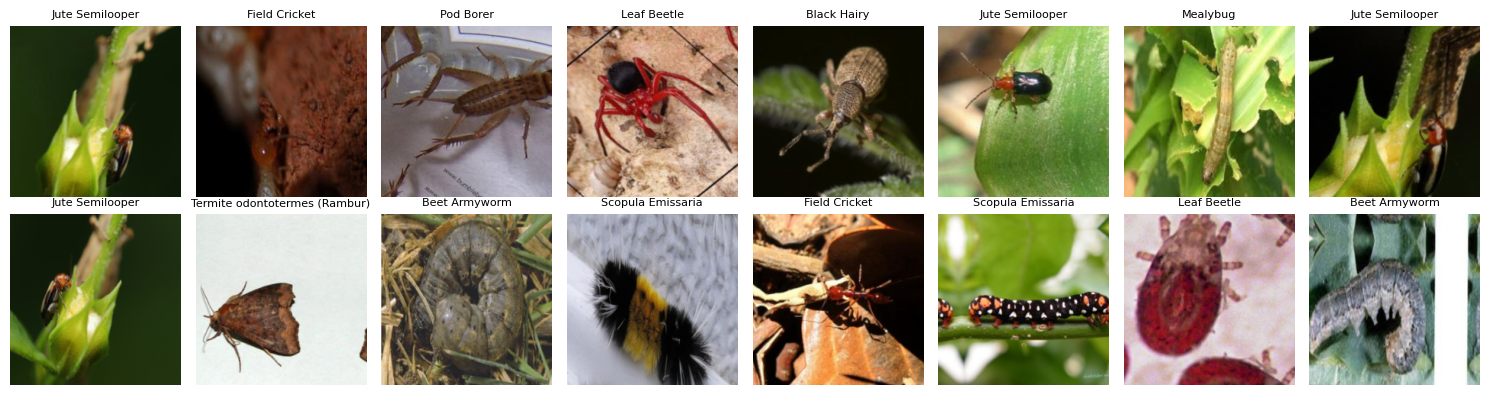

In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def plot_batch(dataloader, classes):
    """
    Plots one batch of images from the DataLoader with labels under each image.

    Args:
        dataloader (DataLoader): The DataLoader object.
        classes (list): List of class names corresponding to labels.
    """
    # Get one batch of data
    images, labels = next(iter(dataloader))
    
    # Denormalize images if normalization was applied
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean  # Denormalize images
    
    # Plot each image with its label
    batch_size = 16
    cols = 8  # Number of images per row
    rows = (batch_size + cols - 1) // cols  # Calculate the required number of rows
    
    plt.figure(figsize=(15, rows * 2))  # Adjust figure size based on rows
    for idx in range(batch_size):
        plt.subplot(rows, cols, idx + 1)
        img = images[idx].permute(1, 2, 0).numpy()  # Rearrange dimensions for matplotlib
        plt.imshow(img)
        plt.axis('off')  # Remove axes for better visualization
        label = classes[labels[idx].item()]  # Convert label index to class name
        plt.title(label, fontsize=8)  # Display label below the image
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_batch(train_loader, class_names)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvoluNet(nn.Module):
    def __init__(self, num_classes=17):
        super(ConvoluNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # (batch_size, 32, 224, 224)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # (batch_size, 64, 224, 224)
        self.relu2 = nn.ReLU()  # (batch_size, 64, 224, 224)
        self.bn2 = nn.BatchNorm2d(64)  # (batch_size, 64, 224, 224)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 64, 112, 112)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # (batch_size, 128, 112, 112)
        self.relu3 = nn.ReLU()  # (batch_size, 128, 112, 112)
        self.bn3 = nn.BatchNorm2d(128)  # (batch_size, 128, 112, 112)
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 128, 56, 56)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # (batch_size, 256, 56, 56)
        self.relu4 = nn.ReLU()  # (batch_size, 256, 56, 56)
        self.bn4 = nn.BatchNorm2d(256)  # (batch_size, 256, 56, 56)
        self.pool4 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 256, 28, 28)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 28, 28)
        self.relu5 = nn.ReLU()  # (batch_size, 512, 28, 28)
        self.bn5 = nn.BatchNorm2d(512)  # (batch_size, 512, 28, 28)
        self.pool5 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 14, 14)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 14, 14)
        self.relu6 = nn.ReLU()  # (batch_size, 512, 14, 14)
        self.bn6 = nn.BatchNorm2d(512)  # (batch_size, 512, 14, 14)
        self.pool6 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 7, 7)

        self.dropout = nn.Dropout(p=0.25)  # (batch_size, 512, 7, 7)

        self.flatten = nn.Flatten()  # (batch_size, 512 * 7 * 7 = 25088)

        self.fc1 = nn.Linear(in_features=7 * 7 * 512, out_features=1024)  # (batch_size, 1024)
        self.relu_fc1 = nn.ReLU()  # (batch_size, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # (batch_size, 1024)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=512)  # (batch_size, 512)
        self.relu_fc2 = nn.ReLU()  # (batch_size, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)  # (batch_size, 512)
      
        self.fc3 = nn.Linear(in_features=512, out_features=256)  # (batch_size, 256)
        self.relu_fc3 = nn.ReLU()  # (batch_size, 256)
        self.bn_fc3 = nn.BatchNorm1d(256)  # (batch_size, 256)
        
        self.fc4 = nn.Linear(in_features=256, out_features=128)  # (batch_size, 128)
        self.relu_fc4 = nn.ReLU()  # (batch_size, 128)
        self.bn_fc4 = nn.BatchNorm1d(128)  # (batch_size, 128)
     
        self.fc5 = nn.Linear(in_features=128, out_features=32)  # (batch_size, 32)
        self.relu_fc5 = nn.ReLU()  # (batch_size, 32)
        self.bn_fc5 = nn.BatchNorm1d(32)  # (batch_size, 32)

        self.fc6 = nn.Linear(in_features=32, out_features=num_classes)  # (batch_size, num_classes)
        
    def forward(self, input):
        output = self.conv1(input)  # (batch_size, 32, 224, 224)
        output = self.conv2(output)  # (batch_size, 64, 224, 224)
        output = self.relu2(output)  # (batch_size, 64, 224, 224)
        output = self.bn2(output)  # (batch_size, 64, 224, 224)
        output = self.pool2(output)  # (batch_size, 64, 112, 112)
    
        output = self.conv3(output)  # (batch_size, 128, 112, 112)
        output = self.relu3(output)  # (batch_size, 128, 112, 112)
        output = self.bn3(output)  # (batch_size, 128, 112, 112)
        output = self.pool3(output)  # (batch_size, 128, 56, 56)
     
        output = self.conv4(output)  # (batch_size, 256, 56, 56)
        output = self.relu4(output)  # (batch_size, 256, 56, 56)
        output = self.bn4(output)  # (batch_size, 256, 56, 56)
        output = self.pool4(output)  # (batch_size, 256, 28, 28)

        output = self.conv5(output)  # (batch_size, 512, 28, 28)
        output = self.relu5(output)  # (batch_size, 512, 28, 28)
        output = self.bn5(output)  # (batch_size, 512, 28, 28)
        output = self.pool5(output)  # (batch_size, 512, 14, 14)

        output = self.conv6(output)  # (batch_size, 512, 14, 14)
        output = self.relu6(output)  # (batch_size, 512, 14, 14)
        output = self.bn6(output)  # (batch_size, 512, 14, 14)
        output = self.pool6(output)  # (batch_size, 512, 7, 7)

        output = self.dropout(output)  # (batch_size, 512, 7, 7)

        output = self.flatten(output)  # (batch_size, 25088)

        output = self.fc1(output)  # (batch_size, 1024)
        output = self.relu_fc1(output)  # (batch_size, 1024)
        output = self.bn_fc1(output)  # (batch_size, 1024)
     
        output = self.fc2(output)  # (batch_size, 512)
        output = self.relu_fc2(output)  # (batch_size, 512)
        output = self.bn_fc2(output)  # (batch_size, 512)
  
        output = self.fc3(output)  # (batch_size, 256)
        output = self.relu_fc3(output)  # (batch_size, 256)
        output = self.bn_fc3(output)  # (batch_size, 256)

        output = self.fc4(output)  # (batch_size, 128)
        output = self.relu_fc4(output)  # (batch_size, 128)
        output = self.bn_fc4(output)  # (batch_size, 128)
 
        output = self.fc5(output)  # (batch_size, 32)
        output = self.relu_fc5(output)  # (batch_size, 32)
        output = self.bn_fc5(output)  # (batch_size, 32)
          
        output = self.fc6(output)  # (batch_size, num_classes)

        # No need for softmax here if using CrossEntropyLoss
        # output = F.softmax(output, dim=1)  # (batch_size, num_classes)

        return output

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [10]:
model = ConvoluNet(num_classes =17).to(device)

In [11]:
from torch.optim import Adam
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=1e-5)
loss_function=nn.CrossEntropyLoss()

In [12]:
epochs = 20

In [13]:
from tqdm import tqdm


def train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for i, (images, labels) in enumerate(train_bar):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item() * images.size(0)  
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

        train_bar.set_postfix(train_loss=train_loss, train_accuracy=train_accuracy)

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    return train_loss, train_accuracy

def test(model, test_loader, test_count):
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += torch.sum(prediction == labels.data).item()

    test_loss = test_loss / test_count
    test_accuracy = test_accuracy / test_count

    return test_loss, test_accuracy

In [14]:
train_count = len(traindataset)
test_count = len(testdataset)

In [15]:
import matplotlib.pyplot as plt

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_accuracy = 0.0

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count)
    test_loss, test_accuracy = test(model, test_loader, test_count)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print('Epoch: ' + str(epoch + 1) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 1 Train Loss: 2.2816997713956826 Train Accuracy: 0.297951582867784 Test Accuracy: 0.37467018469656993


Epoch: 2 Train Loss: 1.7801020625657284 Train Accuracy: 0.4587212911235258 Test Accuracy: 0.43271767810026385


Epoch: 3 Train Loss: 1.431045413017273 Train Accuracy: 0.5594351334574799 Test Accuracy: 0.525065963060686


Epoch: 4 Train Loss: 1.18975472687047 Train Accuracy: 0.6374922408441962 Test Accuracy: 0.6437994722955145


Epoch: 5 Train Loss: 1.0145079088388653 Train Accuracy: 0.6897889509621353 Test Accuracy: 0.6437994722955145


Epoch: 6 Train Loss: 0.8039898041018338 Train Accuracy: 0.755586592178771 Test Accuracy: 0.6992084432717678


Epoch: 7 Train Loss: 0.704233539097062 Train Accuracy: 0.7790192427063936 Test Accuracy: 0.7519788918205804


Epoch: 8 Train Loss: 0.5447028238236127 Train Accuracy: 0.8274363749224084 Test Accuracy: 0.7519788918205804


Epoch: 9 Train Loss: 0.550398671390254 Train Accuracy: 0.8283674736188703 Test Accuracy: 0.7651715039577837


Epoch: 10 Train Loss: 0.418529890991012 Train Accuracy: 0.8679391682184978 Test Accuracy: 0.7335092348284961


Epoch: 11 Train Loss: 0.6234690567708622 Train Accuracy: 0.8202979515828678 Test Accuracy: 0.43271767810026385


Epoch: 12 Train Loss: 0.6526409127118793 Train Accuracy: 0.8078833022967101 Test Accuracy: 0.7994722955145118


Epoch: 13 Train Loss: 0.32578563212904404 Train Accuracy: 0.9020794537554314 Test Accuracy: 0.8073878627968337


Epoch: 14 Train Loss: 0.2947217632087397 Train Accuracy: 0.9065797641216635 Test Accuracy: 0.841688654353562


Epoch: 15 Train Loss: 0.25196274560035054 Train Accuracy: 0.9213221601489758 Test Accuracy: 0.7783641160949868


Epoch: 16 Train Loss: 0.6269015592495748 Train Accuracy: 0.8275915580384854 Test Accuracy: 0.5910290237467019


Epoch: 17 Train Loss: 0.5288044746472627 Train Accuracy: 0.8381440099317194 Test Accuracy: 0.8443271767810027


Epoch: 18 Train Loss: 0.2545429141041583 Train Accuracy: 0.9247361887026692 Test Accuracy: 0.8021108179419525


Epoch: 19 Train Loss: 0.20072365186363922 Train Accuracy: 0.9390130353817505 Test Accuracy: 0.8575197889182058


Epoch: 20 Train Loss: 0.1973640165996433 Train Accuracy: 0.935909373060211 Test Accuracy: 0.841688654353562


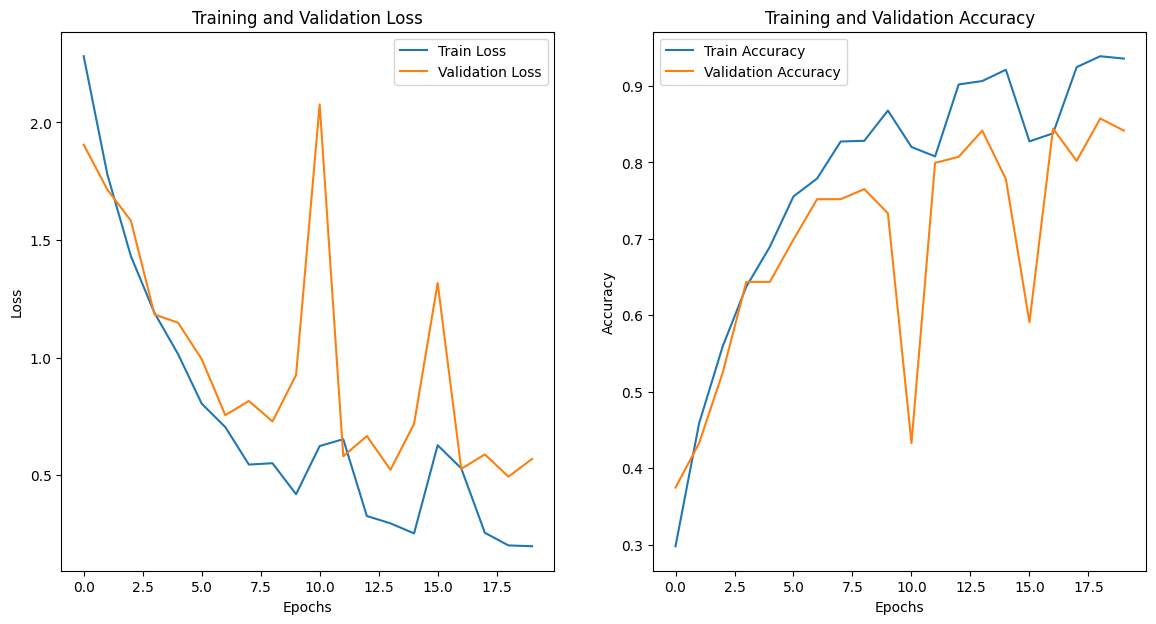

In [16]:
epochs_range = range(epochs)

plt.figure(figsize=(14, 7))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label
         ='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()